In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import warnings
warnings.simplefilter("ignore")

In [85]:
indices = ["^GSPC.csv", "^N225.csv", "^HSI.csv", "^BSESN.csv", "^SSMI.csv", "^BVSP.csv"]
names = ["S&P 500", "N225", "HSI", "BSESN", "SMI", "BVSP"]
data = []
for index in indices:
    df = pd.read_csv("data/"+index, index_col='Date')
    df_t = pd.concat([df['Close'],
                        df['Close']/df['Close'][-1],
                        df['Close'].pct_change(),
                        df['Close'].pct_change().rolling(10).std()], axis=1).dropna()
    df_t.columns = ["Price", "Norm", "Change", "Volume"]
    df_t.index = pd.to_datetime(df_t.index, format='%Y/%m/%d')
    data.append(df_t)

data[5] = data[5].loc['1990-11-09':,:]

#### Drawdowns
To detect crashes, drawdowns are calculated. A drawdown is total loss over consecutive days from last maximum to next mininum price. A drawdown occuring over $n$ days (from $t_1$ to $t_n$) is described as $d=(p_{max}-p_{min})/p_{max}$.

In [86]:
dd_df = []
for i in data:
    p_min_max = (i['Price'].diff(-1) > 0).astype(int).diff()
    pmax = p_min_max[p_min_max == 1]
    pmin = p_min_max[p_min_max == -1]
    if pmin.index[0] < pmax.index[0]:
        pmin = pmin.drop(pmin.index[0])
    if pmin.index[-1] < pmax.index[-1]:
        pmax = pmax.drop(pmax.index[-1])
    dd = (np.array(i['Price'][pmin.index]) - np.array(i['Price'][pmax.index]))/np.array(i['Price'][pmax.index])
    duration = [np.busday_count(p1.date(), p2.date()) for p1, p2 in zip(pmax.index, pmin.index)]
    d = {'Date':pmax.index, 'Drawdown':dd, 'Start':pmax.index, 'End':pmin.index, 'Duration':duration}
    df_d = pd.DataFrame(d).set_index('Date')
    df_d = df_d.sort_values(by='Drawdown')
    df_d['Rank'] = list(range(1, df_d.shape[0]+1))
    dd_df.append(df_d)

#### Identify crashes
Let us identify crashes as the 99.5 empirical percentile on the drawdowns (as suggested by Jacobsson, E., Stockholm University, in 'How to predict crashes in financial markets with the Log-Periodic Power Law', 2009)

In [87]:
crash_thresholds = []
for i in dd_df:
    ct = i['Drawdown'].iloc[round(dd.shape[0] * 0.005)]
    crash_thresholds.append(ct)
    
crashes = []
for df, dd, ct in zip(data, dd_df, crash_thresholds):
    df_d = dd.reindex(df.index).fillna(0)
    df_d = df_d.sort_values(by='Date')
    df_c = df_d[df_d['Drawdown'] < ct]
    df_c.columns = ['Drawdown', 'Start', 'End', 'Duration', 'Rank']
    crashes.append(df_c)

df_combined = []
for i in range(len(data)):
    df_combined.append(pd.concat([data[i], dd_df[i]], axis=1).fillna(0))

In [88]:
idx = 0
for crash in crashes:
    crash['Start'] = crash['Start'].dt.date
    crash['End'] = crash['End'].dt.date
    crash['Duration'] = crash['Duration'].astype(int)
    crash['Rank'] = crash['Rank'].astype(int)
    print(names[idx], " All Crashes since ", str(crash['Start'][0])[0:4])
    display(crash)
    idx += 1

S&P 500  All Crashes since  1962


,Drawdown,Start,End,Duration,Rank
Date,,,,,
1962-05-15,-0.136724,1962-05-15,1962-05-28,9,3
1987-10-13,-0.285133,1987-10-13,1987-10-19,4,1
1987-10-21,-0.118856,1987-10-21,1987-10-26,3,7
1998-08-25,-0.124052,1998-08-25,1998-08-31,4,5
2001-09-10,-0.116005,2001-09-10,2001-09-21,9,8
2002-07-17,-0.119575,2002-07-17,2002-07-23,4,6
2008-09-30,-0.229037,2008-09-30,2008-10-10,8,2
2008-11-18,-0.124174,2008-11-18,2008-11-20,2,4


N225  All Crashes since  1971


,Drawdown,Start,End,Duration,Rank
Date,,,,,
1971-08-13,-0.197097,1971-08-13,1971-08-19,4,3
1974-09-25,-0.169037,1974-09-25,1974-10-09,10,6
1987-10-14,-0.177748,1987-10-14,1987-10-20,4,5
1990-08-15,-0.155609,1990-08-15,1990-08-23,6,7
1990-09-21,-0.149550,1990-09-21,1990-10-01,6,8
2008-10-01,-0.271970,2008-10-01,2008-10-10,7,1
2008-10-21,-0.230313,2008-10-21,2008-10-27,4,2
2011-03-09,-0.187388,2011-03-09,2011-03-15,4,4


HSI  All Crashes since  1987


,Drawdown,Start,End,Duration,Rank
Date,,,,,
1987-10-14,-0.416907,1987-10-14,1987-10-26,8,1
1989-05-29,-0.264112,1989-05-29,1989-06-05,5,3
1992-11-27,-0.168457,1992-11-27,1992-12-03,4,7
1997-10-17,-0.233417,1997-10-17,1997-10-23,4,5
1997-10-24,-0.187037,1997-10-24,1997-10-28,2,6
1997-12-30,-0.244914,1997-12-30,1998-01-12,9,4
2008-10-02,-0.152620,2008-10-02,2008-10-08,4,8
2008-10-20,-0.281092,2008-10-20,2008-10-27,5,2


BSESN  All Crashes since  2000


,Drawdown,Start,End,Duration,Rank
Date,,,,,
2000-04-11,-0.185957,2000-04-11,2000-04-24,9,5
2000-07-12,-0.156305,2000-07-12,2000-07-24,8,8
2001-09-04,-0.170386,2001-09-04,2001-09-17,9,6
2004-05-13,-0.165629,2004-05-13,2004-05-17,2,7
2008-01-11,-0.196736,2008-01-11,2008-01-22,7,3
2008-10-01,-0.193619,2008-10-01,2008-10-10,7,4
2008-10-21,-0.203478,2008-10-21,2008-10-27,4,1
2008-11-10,-0.197904,2008-11-10,2008-11-20,8,2


SMI  All Crashes since  1998


,Drawdown,Start,End,Duration,Rank
Date,,,,,
1998-09-28,-0.166382,1998-09-28,1998-10-05,5,3
2001-09-17,-0.119478,2001-09-17,2001-09-21,4,7
2002-07-17,-0.130555,2002-07-17,2002-07-24,5,5
2003-03-03,-0.122230,2003-03-03,2003-03-12,7,6
2008-10-03,-0.222767,2008-10-03,2008-10-10,5,1
2008-10-20,-0.115101,2008-10-20,2008-10-27,5,8
2011-07-21,-0.177765,2011-07-21,2011-08-08,12,2
2015-01-13,-0.149267,2015-01-13,2015-01-16,3,4


BVSP  All Crashes since  1995


,Drawdown,Start,End,Duration,Rank
Date,,,,,
1995-02-03,-0.273958,1995-02-03,1995-02-16,9,5
1995-02-24,-0.346266,1995-02-24,1995-03-09,9,1
1997-10-21,-0.245774,1997-10-21,1997-10-27,4,7
1998-08-18,-0.234409,1998-08-18,1998-08-27,7,8
1998-09-01,-0.311696,1998-09-01,1998-09-10,7,2
1999-01-06,-0.310190,1999-01-06,1999-01-14,6,3
2008-10-01,-0.284925,2008-10-01,2008-10-10,7,4
2008-10-20,-0.253695,2008-10-20,2008-10-27,5,6


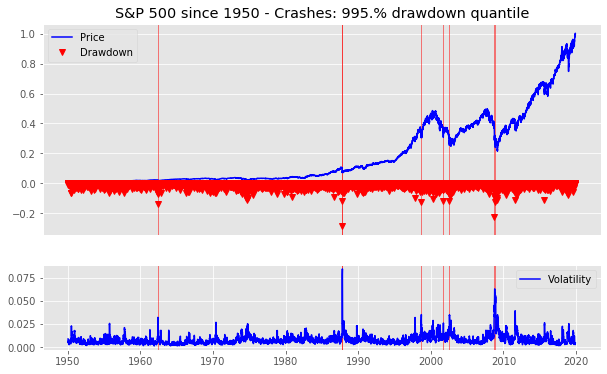

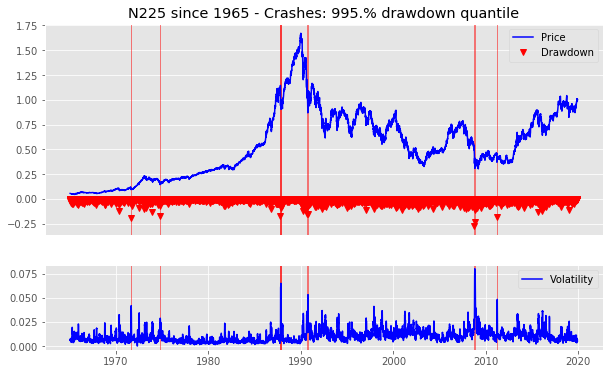

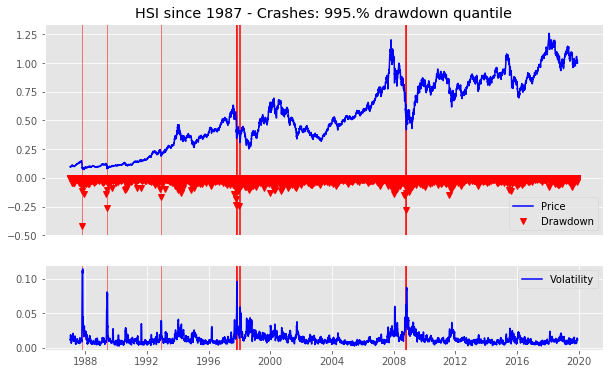

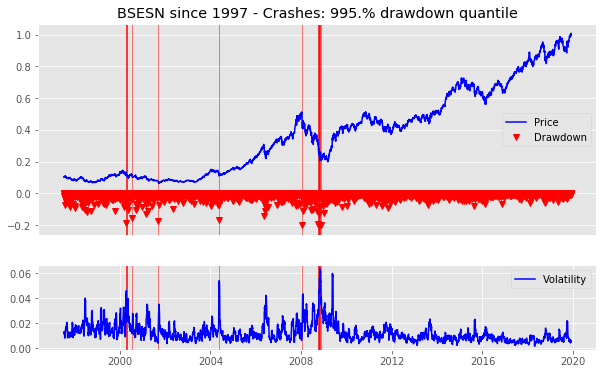

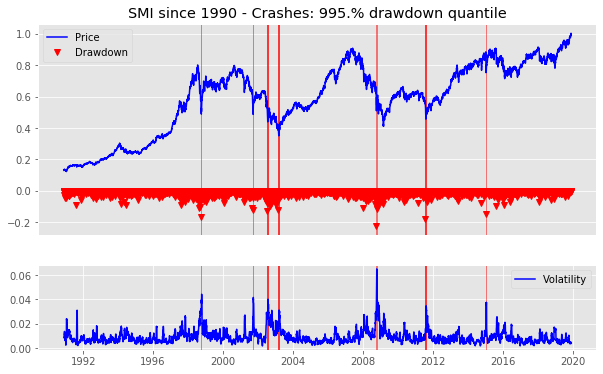

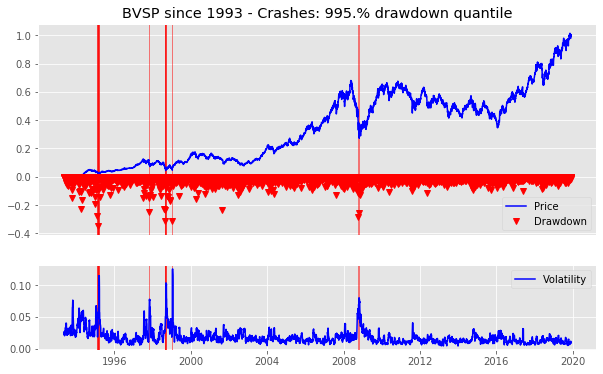

In [89]:
from matplotlib import gridspec
plt.rcParams['figure.figsize'] = 10, 6
gs = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[2.5, 1]) 
idx = 0

for i in range(len(df_combined)):
    plt.subplot(gs[0])
    plt.plot(df_combined[i]['Norm'], color='blue')
    [plt.axvspan(x1, x2, color='red') for x1, x2 in zip(crashes[i]['Start'], crashes[i]['End'])]
    plt.plot(df_combined[i]['Drawdown'], color='red', marker='v', linestyle='')
    plt.title(names[idx]+" since "+str(df_combined[i].index[0])[0:4]+" - Crashes: 995.% drawdown quantile")
    idx += 1
    plt.xticks([])
    plt.legend(['Price', 'Drawdown'])
    
    plt.subplot(gs[1])
    plt.plot(df_combined[i]['Volume'], color='blue')
    [plt.axvspan(x1, x2, color='red') for x1, x2 in zip(crashes[i]['Start'], crashes[i]['End'])]
    plt.legend(['Volatility'])
    
    plt.show()

The drawdown threshold for identifying a crash varies strongly with markets and we do not account for the fact that some markets have much more extreme large drawdowns than others.